# Test Dataloader in dataset.py

In [49]:
# install packages
import yaml
import os
import json
from torch.utils.data import Dataset
from torchvision.transforms import Compose, Resize, ToTensor
from PIL import Image
import matplotlib.pyplot as plt


Import Data/Annotations

In [27]:
config_file_path = '/home/Alexandra/Projects/bodycondition/sharkbody_seg/runs/unet_smp/demo_run/config/config.yaml' # config file path

with open(config_file_path, 'r') as file: cfg = yaml.safe_load(file) # load yaml as cfg

Functions from earth_obs_seg (Bjorn)

In [40]:
class SharkBody(Dataset):

    def __init__(self, cfg, split='train'):
        '''
            Constructor. Here, we collect and index the dataset inputs/labels.
        '''
        self.data_root = cfg['data_root'] 
        self.split = split
        #  Transforms. Here's where we could add  augmentation. For now, we resize images & convert to torch.Tensor.

        self.transform = Compose([              
            Resize((cfg['image_size'], cfg['image_size'])),        
            ToTensor()                          
        ])
        
        # index data into list
        self.data = []

        # load annotation file
        annoPath = os.path.join(
            self.data_root,
            'annotations',
            'train.json' if self.split == 'train' else ('val.json' if self.split == 'val' else 'test.json') # choose one of three splits
        )
        meta = json.load(open(annoPath, 'r'))

        # enable filename lookup. Creates image IDs and assigns each ID one filename. 
        images = dict([[i['id'], i['file_name']] for i in meta['images']])
        # create custom indices for each category that start at zero; should only have one
        labels = dict([[c['id'], idx] for idx, c in enumerate(meta['categories'])])
        
        # taking the first annotation per image and drop the rest
        images_covered = set()      # all those images for which we have already assigned a label
        for anno in meta['annotations']:
            imgID = anno['image_id']
            if imgID in images_covered:
                continue
            
            # append image-label tuple to data
            imgFileName = images[imgID]
            label = anno['category_id']
            labelIndex = labels[label]
            self.data.append([imgFileName, labelIndex])
            images_covered.add(imgID)       # make sure image is only added once to dataset
    

    def __len__(self):
        return len(self.data)

    
    def __getitem__(self, idx):

        image_name, label = self.data[idx]

        # load image
        image_path = os.path.join(self.data_root, 'images', image_name)
        img = Image.open(image_path).convert('RGB')   # the ".convert" makes sure we always get three bands in Red, Green, Blue order

        # transform: see lines 31ff above where we define our transformations
        img_tensor = self.transform(img)

        return img_tensor, label

# Test each function

In [41]:
# instantiate shark body
dataset = SharkBody(cfg, split='train')

Load example image

In [31]:
image_path = '/mnt/class_data/group2/alexandradigiacomo/dataset/images/05122024PAMB0101.JPG'  # first image
img = Image.open(image_path).convert('RGB')

In [51]:
# test data loader
for i in range(5):
    print(dataset[i])  # Should print (image_tensor, label)

(tensor([[[0.4588, 0.4549, 0.4510,  ..., 0.3725, 0.3686, 0.3725],
         [0.4549, 0.4510, 0.4510,  ..., 0.3725, 0.3686, 0.3725],
         [0.4549, 0.4510, 0.4510,  ..., 0.3765, 0.3765, 0.3765],
         ...,
         [0.3922, 0.3882, 0.3843,  ..., 0.3725, 0.3725, 0.3725],
         [0.3922, 0.3843, 0.3843,  ..., 0.3725, 0.3725, 0.3765],
         [0.3882, 0.3804, 0.3843,  ..., 0.3725, 0.3725, 0.3765]],

        [[0.6235, 0.6196, 0.6196,  ..., 0.5647, 0.5608, 0.5608],
         [0.6196, 0.6196, 0.6196,  ..., 0.5647, 0.5608, 0.5608],
         [0.6196, 0.6157, 0.6196,  ..., 0.5647, 0.5647, 0.5608],
         ...,
         [0.5686, 0.5686, 0.5647,  ..., 0.5529, 0.5529, 0.5569],
         [0.5686, 0.5647, 0.5647,  ..., 0.5529, 0.5529, 0.5569],
         [0.5686, 0.5647, 0.5647,  ..., 0.5529, 0.5569, 0.5569]],

        [[0.5451, 0.5412, 0.5451,  ..., 0.4392, 0.4353, 0.4353],
         [0.5412, 0.5412, 0.5412,  ..., 0.4392, 0.4353, 0.4353],
         [0.5412, 0.5373, 0.5412,  ..., 0.4392, 0.4392, 0

In [26]:
# test len function
print(len(dataset)) 

888


In [42]:
# test the __getitem__ function
img_tensor, label = dataset[0]

# Check the shape of the image tensor and label
print(f"Image tensor shape: {img_tensor.shape}")  # Should match (3, height, width)
print(f"Label: {label}")  # Should print the corresponding label index=

Image tensor shape: torch.Size([3, 224, 224])
Label: 0


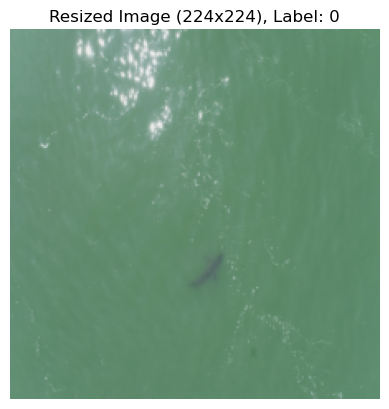

Label: 0


In [ ]:
# plot the resized image
img_display = img_tensor.permute(1, 2, 0)  # Convert from [3, 224, 224] to [224, 224, 3]

plt.imshow(img_display) # display
plt.title(f"Resized Image (224x224), Label: {label}")
plt.axis('off')  # Hide axis
plt.show()

print(f"Label: {label}") # print the label